# Proyecto del Curso

### Cargar los datos

Vamos a trabajar con un dataset de lenguajes de señas. Para ello, vamos a descargar los datos de la nube de Google

In [1]:
!wget --no-check-certificate https://storage.googleapis.com/platzi-tf2/sign-language-img.zip \ -O ./sign-language-img.zip

--2024-11-01 09:08:46--  https://storage.googleapis.com/platzi-tf2/sign-language-img.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.132.91, 142.251.132.123, 142.251.132.155, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.132.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24265584 (23M) [application/zip]
Saving to: ‘sign-language-img.zip’

sign-language-img.z 100%[===================>]  23.14M  1.50MB/s    in 20s     

2024-11-01 09:09:07 (1.15 MB/s) - ‘sign-language-img.zip’ saved [24265584/24265584]

--2024-11-01 09:09:07--  http://%20-o/
Resolving  -o ( -o)... failed: Name or service not known.
wget: unable to resolve host address ‘ -o’
--2024-11-01 09:09:07--  http://./sign-language-img.zip
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2024-11-01 09:09:07--
Total wall clock time: 21s
Downloaded: 1 files, 23M in 20s (1.15 MB/s)


Una vez descargado el archivo .zip en nuestro entorno local, procedemos a  descomprimirlo

In [2]:
import os
import zipfile

In [ ]:
# ruta donde se encuentra el .zip
path_zip = './sign-language-img.zip'

# obtencion de los archivos de zip
zip_ref = zipfile.ZipFile(path_zip, 'r')
zip_ref.extractall('./sign-language-img')
zip_ref.close()

La estructura del dataset constará en 2 directorios principales: Test y Train, donde para cada clase (letra en señas) tendremos un directorio con sus respectivos ejemplos.

### Cargar el dataset con Keras dataset generator

Procedemos a cargar las librerias necesarias.

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import tensorflow as tf

# libreria para trabajar con las bases de datos 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Cargamos las rutas donde se encuentra nuestro dataset

In [5]:
train_dir = './sign-language-img/Train'
test_dir = './sign-language-img/Test'

Generamos los data generators al mismo tiempo que reescalamos los datos al rango entre 0 y 1 para mejorar la convergencia del modelo. Ademas. dividimos el 20% de los datos de prueba a validacion para monitorear el rendimiento del modelo en vivo

In [6]:
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

Para cargar las imágenes, haremos uso del método flow_from_directory del generador, determinaremos el directorio fuente, el tamaño que tendrán las imágenes (el generador las redimensionará de ser necesario), los lotes de procesamiento, el tipo de clases, el tipo de escala de colores y el subset al que pertenecen.

In [7]:
# para datos de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training'
)

# para daros de validacion
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation'
)

# para daros de prueba
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)

Found 27455 images belonging to 24 classes.
Found 1425 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


> Hay 27455 imagenes de training.

> Hay 1425 imagenes de validacion.

> Hay 7172 imagenes de test.

Para generar las clases haremos una pequeña list comprehension recorriendo los caracteres ASCII omitiendo las letras J y Z debido a que estas letras se representan con movimiento. Se descartan

In [8]:
classes = [char for char in string.ascii_uppercase if char != 'J' if char != 'Z']

In [9]:
# veamos la lista de las clases
classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y']

Para graficar imágenes crearemos la función plotImages que recibirá un array de imágenes y las mostrará en pantalla en grupos de 5.

In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize = (10, 10))
    axes = axes.flatten()

    for img, ax in zip(images_arr, axes):
        ax.imshow(img[:,:,0])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Para hacer uso de esta función generaremos un conjunto de imágenes, esto nos retornará un array de imágenes que daremos como parámetro.

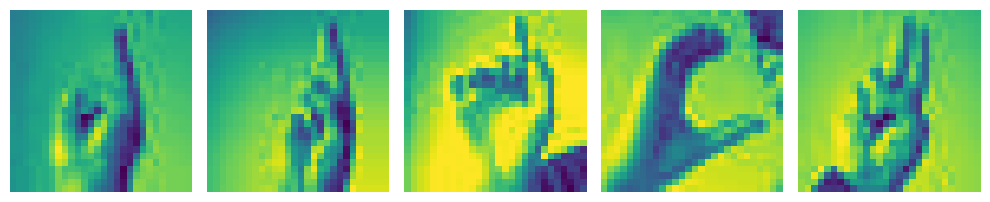

In [12]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])

Con esto hemos cargado imágenes en memoria sin necesidad de saturar la memoria del sistema, cada vez que requieras iterar sobre tu dataset el generador solo generará las imágenes necesarias.

### Crear el Modelo

Definiremos un modelo con la clase Sequential de Keras, esta nos permitirá apilar varias capas una encima de otra para lograr el efecto de aprendizaje profundo.

La primer capa será de entrada, donde recibiremos una imagen de 28x28 pixeles en un solo canal, una vez recibida será aplanada para ser procesada como un array unidimensional.

Las siguientes 2 capas serán capas profundas con 256 y 128 neuronas respectivamente, y tendrán como función de activación la ReLU.

La capa de salida será una capa de 24 neuronas (una por cada posible clase) de activación Softmax que nos retornará un array con las probabilidades de cada letra.

In [15]:
model_base = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(classes), activation='softmax')
]
)

/home/jbernal/anaconda3/envs/tf_cpu/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Con el metodo summary obtenemos un resumen de la arquitectura de la red

In [16]:
model_base.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,952 (925.59 KB)

 Trainable params: 236,952 (925.59 KB)

 Non-trainable params: 0 (0.00 B)

El resumen nos muestra:

> Capa de entrada constituida por 784 neuronas

> Capas intermedias de 256 y 128 neuronas. La primera con 200960 conexiones y la segunda con 2896 conexiones.

> Capa de salida con 24 neuronas

> Param # es el numero de multiplicaciones del modelo

### Compilacion y entrenamiento del modelo

Compilaremos el modelo definiendo un optimizador, para este caso determinamos adam, un algoritmo que permite actualizar automáticamente el learning rate según el desempeño de la red. Como función de pérdida aplicaremos categorical cross entropy y la métrica de éxito será la precisión.

In [17]:
model_base.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
    )

Entrenaremos el modelo con el image generator de entrenamiento, durante 20 épocas y con los datos de validación.

In [18]:
history = model_base.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

/home/jbernal/anaconda3/envs/tf_cpu/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - accuracy: 0.2295 - loss: 2.6629 - val_accuracy: 0.4996 - val_loss: 1.6984
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.6224 - loss: 1.2742 - val_accuracy: 0.6112 - val_loss: 1.3177
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.7284 - loss: 0.8955 - val_accuracy: 0.6519 - val_loss: 1.1505
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.8166 - loss: 0.6243 - val_accuracy: 0.6435 - val_loss: 1.1257
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.8537 - loss: 0.4916 - val_accuracy: 0.7032 - val_loss: 1.0078
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - accuracy: 0.9009 - loss: 0.3617 - val_accuracy: 0.6996 - val_loss: 1.0024
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9261 - loss: 0.2730 - val_accuracy: 0.6926 - val_loss: 1.0275
Epoch 8/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9372 - loss: 0.2293 -

> En la época final tendremos una precisión casi total  del 99% durante el entrenamiento pero un rendimiento diferente sobre los datos de validación de 77.6%

Si evaluamos el modelo, nos encontraremos con una precisión del 76%, donde el entrenamiento era casi absoluta.

In [19]:
model_base.evaluate(test_generator)

/home/jbernal/anaconda3/envs/tf_cpu/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.7837 - loss: 1.1035


[1.1422247886657715, 0.7787228226661682]

### Analisis del desempeño del la red

Para entender gráficamente lo que sucedió, crearemos la función de visualización de resultados, que comparará el rendimiento del entrenamiento sobre el rendimiento de validación tanto términos de accuracy como de loss.

In [20]:
def visualizacion_resultados(history):
    epochs = [i for i in range(20)]
    fig, ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    fig.set_size_inches(16,9)
    ax[0].plot(epochs, train_acc, 'go-', label='Entrenamiento accuracy')
    ax[0].plot(epochs, val_acc, 'ro-', label='Validacion accuracy')
    ax[0].set_title('Entrenamiento y validacion accuracy')
    ax[0].legend()
    ax[0].set_xlabel('Epocas')
    ax[0].set_ylabel('Accuracy')

    ax[1].plot(epochs, train_loss, 'go-', label='Entrenamiento accuracy')
    ax[1].plot(epochs, val_loss, 'ro-', label='Validacion accuracy')
    ax[1].set_title('Entrenamiento y validacion accuracy')
    ax[1].legend()
    ax[1].set_xlabel('Epocas')
    ax[1].set_ylabel('Loss')

    plt.show()

Si corremos la función obtendremos información valiosísima con respecto al comportamiento del modelo.

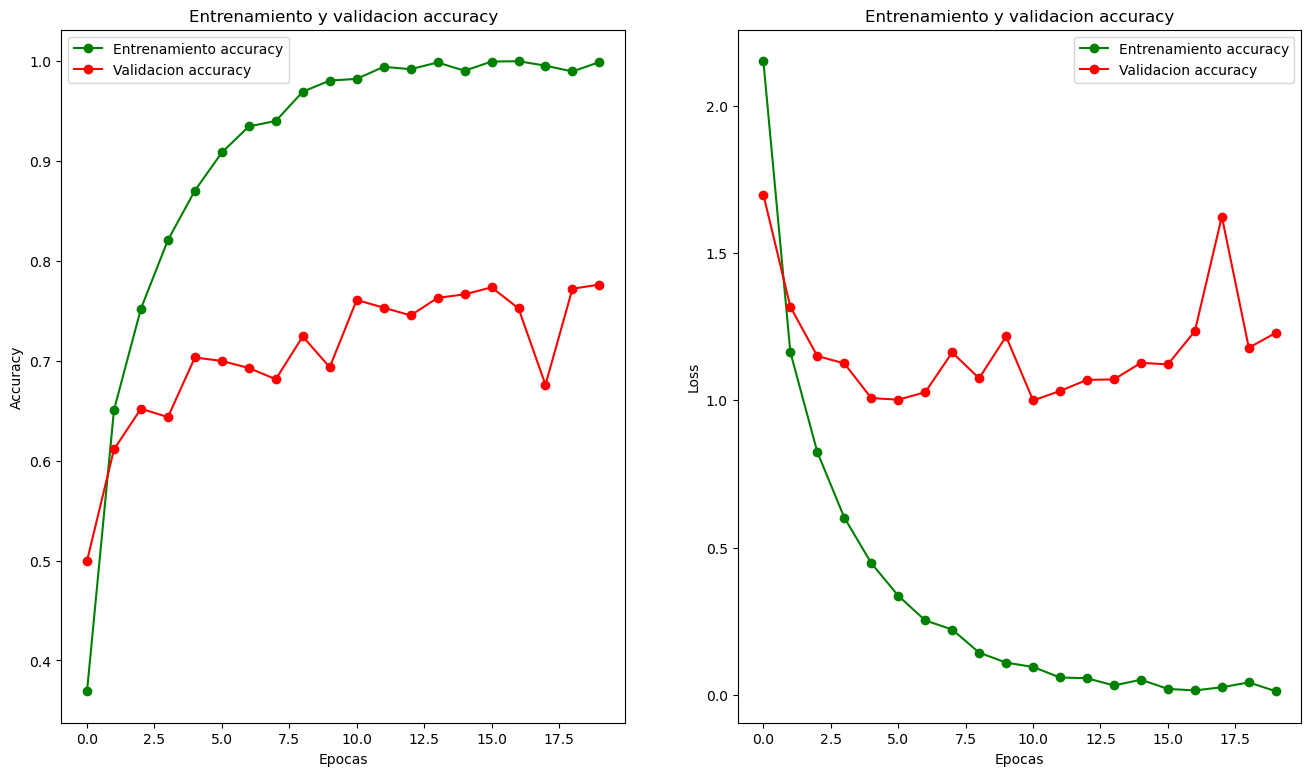

In [21]:
visualizacion_resultados(history)